# [실습] LangGraph 그래프 기초

랭그래프는 어플리케이션의 작동 과정을 Graph로 정의하고, 이를 통해 복잡한 Workflow를 실행합니다.   

랭체인이 단순히 입력--> 출력의 과정을 모델링했다면, 랭그래프는 여기에 분기와 반복, 모니터링과 같은 기능을 효과적으로 추가할 수 있습니다.   

기본 라이브러리를 설치합니다.

In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai langchain_community duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uninst

# Graph의 구성 요소: State, Node, Edge, Graph


시작 지점과 끝 지점을 표시한 그래프를 구성하고, 전체 그래프를 `invoke()`를 통해 실행합니다.

그래프는 점과 선으로 구성되는데요.  



이를 노드(Node, 정점), 엣지(Edge, 간선)라고 부릅니다.    

각각의 노드는 LLM 호출을 비롯한 하나의 기능을 수행하게 되며, 기능과 기능 사이의 연결을 엣지로 구성합니다.

### State

LangGraph의 Workflow는 State Diagram으로 볼 수 있습니다.   

각각의 Node와 Edge는 State에 저장된 값을 통해 연결됩니다.   


매번의 라는 개념을 통해 연결됩니다.    


State의 구조는 보통 가시성을 위해 타입 표시를 병행합니다.   
`TypedDict`나 `Pydantic`중 편한 것을 사용하면 되는데요.   
이번 교재에서는 공식 문서와 동일한 `TypedDict`를 사용하겠습니다.

In [ ]:
# TypedDict: 타입 표시가 가능한 구조

from typing_extensions import TypedDict

class State(TypedDict):
    result: str

### Node

노드는 함수로 정의되는데, 주로 하나의 모듈을 하나의 노드로 구성합니다.   
State는 노드를 지나며 새로운 정보를 추가하거나, 값을 수정할 수 있습니다.

In [ ]:
# state에 문자열을 추가하는 노드

def first(state):
    print("---Node 1---")
    return {"result": state['result'] +"랭그래프 1번 노드 통과\n"}

def second(state):
    print("---Node 2---")
    return {"result": state['result'] +"랭그래프 2번 노드 통과\n"}

### Edge와 Graph   

위에서 설정한 State를 이용하여 Graph를 정의합니다.

그래프에 노드와 엣지를 추가합니다.    
START와 END를 import하고, 시작점과 끝점을 정의합니다.

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 그래프 정의하기
builder = StateGraph(State)

# 노드 이름과 함수 이름은 같지 않아도 됨
builder.add_node("first", first)
builder.add_node("second", second)

builder.add_edge(START, "first")
builder.add_edge("first", "second")
builder.add_edge("second", END)

만든 그래프는 `compile()`을 통해 실행 가능한 Runnable 구조로 만들어집니다.

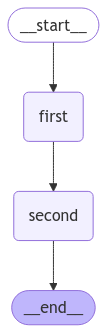

In [ ]:
graph = builder.compile()

graph
# 간단한 Mermaid 기반의 시각화 지원

구성된 graph를 실행해 보겠습니다!   
state의 초기 상태를 Dictionary 형태로 전달합니다.

In [ ]:
response = graph.invoke({'result':'시작!\n'})
response

---Node 1---
---Node 2---


{'result': '시작!\n랭그래프 1번 노드 통과\n랭그래프 2번 노드 통과\n'}

## 그래프에 LLM 포함시키기
이번에는 값이 여러 개인 State를 구성하고, 그래프로 만들어 보겠습니다.   
llm도 활용해 보겠습니다.

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=rate_limiter
)

<ipython-input-7-d42834849852>:9: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


3개의 요소가 포함된 State를 구성합니다.

In [ ]:
class State(TypedDict):
    integer: int
    root: int
    joke: str


2개의 노드를 구성합니다.

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def get_root(state):
    return {"root": int(state["integer"] ** 0.5)}

def get_joke(state):
    prompt = ChatPromptTemplate([
        ('system', '당신은 언어 유희의 달인입니다.'),
         ('user','{length} 문장 길이의 짧은 유머를 만들어주세요. 각 문장마다 숫자를 붙이세요.')
    ])
    chain = prompt | llm | StrOutputParser()
    return {"joke": chain.invoke({'length':state['root']})}

그래프를 구성합니다.

In [ ]:
# 그래프 구성
builder = StateGraph(State)

builder.add_node("get_root", get_root)
builder.add_node("get_joke", get_joke)

builder.add_edge(START, "get_root")
builder.add_edge("get_root", "get_joke")
builder.add_edge("get_joke", END)

그래프를 컴파일하고 실행합니다.

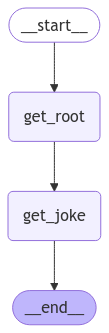

In [ ]:
graph = builder.compile()
graph

In [ ]:
initial_state = {'integer': 16}
response = graph.invoke(initial_state)

response

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
    self._credentials.before_request(
  File "/usr/local/lib/python3.11/dist-packages/google/auth/credentials.py", line 228, in before_request
    self._blocking_refresh(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/credentials.py", line 191, in _blocking_refresh
    self.refresh(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 134, in refresh
    raise new_exc from caught_exc
google.auth.exceptions.RefreshError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7c251d367690>)
ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7c251d4f5010>" raised exception!
Traceback (most recent call last):
  File "/usr/lo

RetryError: Timeout of 600.0s exceeded, last exception: 503 Getting metadata from plugin failed with error: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7c251c102d90>)

### 웹 검색 노드 만들기   


이번 실습에서는 웹 검색 툴 결과를 바탕으로, 실제 URL을 크롤링하여 문서의 내용을 가져오겠습니다.   

랭체인에서 웹 페이지를 크롤링하기 위해서는 대표적으로 아래 3개의 방법을 사용할 수 있습니다.

1. `WebBaseLoader` : BeautifulSoup4 기반의 기본 크롤러로, HTML 코드를 그대로 가져옵니다.
2. `Docling` : 다양한 포맷의 문서를 텍스트 포맷으로 변환하는 오픈 소스 프로젝트로, 유용하나 빠른 실행을 위해 GPU 성능이 다소 요구됩니다.
3. `FireCrawl`: API 기반의 유료 서비스로, 무료 라이센스는 총 500회 무료 사용이 가능합니다.   

이후의 프로젝트에서는 고성능 파서를 활용하지만, 이번 실습은 WebBaseLoader를 사용하겠습니다 :)

In [ ]:
os.environ['TAVILY_API_KEY'] = ''

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader

def tavily_search(State):
    tavily_search = TavilySearchResults(max_results=5)

    # 검색 결과 수집
    search_results = tavily_search.invoke({'query': State['query']})

    # URL 리스트 추출
    urls = [result['url'] for result in search_results]


    try:
        loader = WebBaseLoader(urls)
    except:
        loader = WebBaseLoader(urls, requests_kwargs={'verify':False})

    documents = loader.load()
    return {'context': documents}

result = tavily_search({'query': '변형호'})
result


In [ ]:
def get_query(State):
    prompt = ChatPromptTemplate([
         ('user','{question}에 답변하기 위해, 인터넷 검색을 사용하려고 합니다. 적절한 검색어 쿼리를 하나만 출력하세요. 쿼리만 출력하세요.')
    ])
    chain = prompt | llm | StrOutputParser()
    return {"query": chain.invoke(State)}


def answer_query(State):
    prompt = ChatPromptTemplate([
        ('system', '''당신은 QA(Question-Answering)을 수행하는 Assistant입니다.
다음의 Context를 이용하여 Question에 답변하세요.
정확한 답변을 제공하세요.
만약 모든 Context를 다 확인해도 정보가 없다면,
"정보가 부족하여 답변할 수 없습니다."를 출력하세요.'''),

        ('user', '''Context: {context}
---
Question: {query}''')])
    chain = prompt | llm | StrOutputParser()
    return {"answer": chain.invoke(State)}

State를 만들고, 그래프를 구성합니다.

In [ ]:
class State(TypedDict):
    question : str
    query: str
    context: str
    answer: str


In [ ]:
# 그래프 구성
builder = StateGraph(State)

builder.add_node("get_query", get_query)
builder.add_node("tavily_search", tavily_search)
builder.add_node("answer_query", answer_query)

builder.add_edge(START, "get_query")
builder.add_edge("get_query", "tavily_search")
builder.add_edge("tavily_search", "answer_query")
builder.add_edge("answer_query", END)


In [ ]:
graph = builder.compile()
graph

In [ ]:
result = graph.invoke({'question': 'DeepSeek R1의 특징이 뭐야?'})
print(result)

전체 결과가 잘 실행되었지만, 중간 결과가 보고 싶다면 어떻게 해야 할까요?   
이후에 배울 `LangSmith`를 통해 트래킹할 수도 있고, 아래의 코드로 각 단계를 스트리밍할 수도 있습니다.

In [ ]:
import pprint

# Streaming 참고
# https://langchain-ai.github.io/langgraph/concepts/streaming/#streaming-graph-outputs-stream-and-astream

for data in graph.stream({'question': '한국어 잘 하는 오픈 LLM 모델이 뭐야?'}, stream_mode='updates'):
    pprint.pprint(data)

결과는 잘 나왔지만, 위 검색 결과를 보면 프롬프트에 포함하지 않아도 되는 검색 결과들이 많이 존재합니다.    

더 효과적인 어플리케이션을 구성한다면, 검색 결과를 사전에 검증하여 불필요한 토큰을 줄이거나,   
다양한 소스를 검색하거나, 검색 결과와 RAG의 결과를 바탕으로 쿼리를 재구성할 수도 있습니다.   



이번 실습에서는 단순한 일직선 형태의 Flow를 그래프로 만들었기 때문에 위 작업들을 수행하지 않았지만,    
LangGraph의 기능을 활용하면 반복, 분기점, 중단 및 사용자의 중간 개입과 같은 요소들을 효율적으로 포함할 수 있습니다.    

